In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

pd.options.display.max_rows = 101

In [2]:
#     IMPORTS

# read in data files
food_services_df = pd.read_excel('db/FoodServicesAllReporting.xlsx')
public_facilities_df = pd.read_excel('db/PublicFacilitiesAllReporting.xlsx')
whsl_retail_manufacture_df = pd.read_excel('db/WholesaleRetailManufacturersAllReporting.xlsx')
receiving_food_df = pd.read_excel('db/FoodBanksReceiving.xlsx')

# create one base datafram
frames = [food_services_df, public_facilities_df, whsl_retail_manufacture_df]
food_output_df = pd.concat(frames)





#     DATAFRAME REVIEW
# food_services_df.head()
# public_facilities_df.head()
# whsl_retail_manufacture_df.head()
# receiving_food_df.head()
# food_output_df.head()
# food_output_df.describe

In [3]:
#     DATA CLEANING

# strip hanging space on 'Full-Service Restaurants'
naics = 'NAICS_CODE_DESCRIPTION'
food_output_df.loc[food_output_df[naics]=='Full-Service Restaurants ', naics] = 'Full-Service Restaurants'
# strip lead/trail space on specified columns (different method)
food_output_df['NAME'] = food_output_df['NAME'].str.strip()
food_output_df['ADDRESS'] = food_output_df['ADDRESS'].str.strip()
food_output_df['CITY'] = food_output_df['CITY'].str.strip()
food_output_df['COUNTY'] = food_output_df['COUNTY'].str.strip()
food_output_df['STATE'] = food_output_df['STATE'].str.strip()
food_output_df['UNIQUEID'] = food_output_df['UNIQUEID'].str.strip()
food_output_df['NAICS_CODE_DESCRIPTION'] = food_output_df['NAICS_CODE_DESCRIPTION'].str.strip()

In [4]:
#     EXPLORE CODE DESCRIPTIONS

# len 79 with 3 types of schools = 76
description_list = food_output_df['NAICS_CODE_DESCRIPTION'].unique()
description_df = pd.DataFrame(description_list).drop([13,14,15], axis=0).reset_index(drop=True)
description_df.columns = ['NAICS_CODE_DESCRIPTION']
# description_df

In [5]:
#     EXPLORE CODES

# len 77 with 1 school = 76
code_list = food_output_df['NAICS_CODE'].unique()
codes_df = pd.DataFrame(code_list).drop([13], axis=0).reset_index(drop=True)
codes_df.columns = ['NAICS_CODE']
# codes_df

In [6]:
#     PAIR DESCRIPTIONS WITH APPROPRIATE CODE FOR FILTERING DATA INTO SPECIFIC DATAFRAMES

NAICSpairs = pd.concat([codes_df, description_df], axis=1)
# NAICSpairs.sort_values('NAICS_CODE', inplace=True)
NAICSpairs.sort_values('NAICS_CODE_DESCRIPTION', inplace=True)
NAICSpairs.reset_index(drop=True, inplace=True)
NAICS_kvp_list = NAICSpairs.to_dict('split')['data']
# NAICSpairs

#### NAICSpairs [NAICS code-NAICS description] being deleted from food_output_df:<br>
311999 - All Other Miscellaneous Food Manufacturing<br>
311313 - Beet Sugar Manufacturing<br>
312120 - Breweries<br>
311314 - Cane Sugar Manufacturing<br>
311351 - Chocolate and Confectionery Manufacturing from Cacao Beans<br>
311920 - Coffee and Tea Manufacturing<br>
311352 - Confectionery Manufacturing from Purchased Chocolate<br>
424450 - Confectionery Merchant Wholesalers<br>
445292 - Confectionery and Nut Stores<br>
312140 - Distilleries<br>
311930 - Flavoring Syrup and Concentrate Manufacturing<br>
311211 - Flour Milling<br>
311520 - Ice Cream and Frozen Dessert Manufacturing<br>
311213 - Malt Manufacturing<br>
311340 - Nonchocolate Confectionery Manufacturing<br>
311212 - Rice Milling<br>
722515 - Snack and Nonalcoholic Beverage Bars<br>
312111 - Soft Drink Manufacturing<br>
311942 - Spice and Extract Manufacturing<br>
311221 - Wet Corn Milling<br>
312130 - Wineries<br>

In [7]:
#     FINAL_OUTPUT = CLEANED EXCESS PRODUCERS BY DROPPING NON-USABLE FOOD PRODUCTS

drop_codes = ([311999,311313,312120,311314,311351,311920,311352,424450,445292,312140,311930,
               311211,311520,311213,311340,311212,722515,312111,311942,311221,312130])
final_output = food_output_df[~food_output_df['NAICS_CODE'].isin(drop_codes)]
# final_output.head()
# final_output.count()

In [8]:
#     INDIVIDUAL DATAFRAMES (TABLES FOR .sqlite FILE)

# pull ALL schools
all_schools_df = final_output[final_output['NAICS_CODE']=='SCHOOL']

# pull public schools
public_schools_df = final_output[final_output['NAICS_CODE_DESCRIPTION']=='TYPE: Public Elementary & Secondary']

# pull private schools
private_schools_df = final_output[final_output['NAICS_CODE_DESCRIPTION']=='TYPE: Private Elementary & Secondary']

# pull postsecondary schools
postsecondary_schools_df = final_output[final_output['NAICS_CODE_DESCRIPTION']=='TYPE: Postsecondary']




# pull correctional facilities
corrections_df = final_output[final_output['UNIQUEID'].str.contains('COR')]




# pull healthcare facilities & drop 'Specialty (except Psychiatric and Substance Abuse) Hospitals'
healthcare_df = (final_output[final_output['UNIQUEID'].str.contains('HEA') 
                 & ~final_output['NAICS_CODE_DESCRIPTION'].str.contains('Specialty')])




# pull restaurants/hotels/caterers/casinos [HOSPITALITY]
restaurants_codes = [311811,722330,722511,722513,722514,721120,713210,722320,721110]
restaurant_df = final_output[final_output['NAICS_CODE'].isin(restaurants_codes)]




# pull grocery/market/wholesale/food clubs
grocery_df = (final_output[final_output['NAICS_CODE_DESCRIPTION'].str.contains('Club', case=False) 
              | final_output['NAICS_CODE_DESCRIPTION'].str.contains('Market', case=False) 
              | final_output['NAICS_CODE_DESCRIPTION'].str.contains('Merchant', case=False)
              | final_output['NAICS_CODE'].isin([445299,445291])])




# pull manufacturers/producers/processers
production_df = (final_output[final_output['NAICS_CODE_DESCRIPTION'].str.contains('Pro', case=False)
                 | final_output['NAICS_CODE_DESCRIPTION'].str.contains('Canning', case=False) 
                 | final_output['NAICS_CODE_DESCRIPTION'].str.contains('Commercial', case=False) 
                 | final_output['NAICS_CODE_DESCRIPTION'].str.contains('Manufactur', case=False) 
                 | final_output['NAICS_CODE_DESCRIPTION'].str.contains('Refining', case=False)                            
                 | final_output['NAICS_CODE_DESCRIPTION'].str.contains('Slaughter', case=False)])
production_df = production_df[~production_df['NAICS_CODE_DESCRIPTION'].str.contains('Merchant', case=False)]





#     DATAFRAME REVIEW
# all_schools_df.head()
# public_schools_df.head()
# private_schools_df.head()
# postsecondary_schools_df.head()
# corrections_df.head()
# healthcare_df.head()
# restaurant_df.head()
# grocery_df.head()
# production_df.head()

In [9]:
#     DATA EXPLORATION: occurrences of each zip code
# final_output['ZIP_CODE'].value_counts()

In [10]:
#     INDIVIDUAL DATAFRAMES (TABLES FOR .sqlite FILE) CONT.

# total excess food produced by zip, ordered by descending EXCESSFOOD_TONYEAR_LOWEST sum
low_excessfood_by_zipcode = (final_output.groupby('ZIP_CODE')
                         ['EXCESSFOOD_TONYEAR_LOWEST', 'EXCESSFOOD_TONYEAR_HIGHEST']
                         .sum().sort_values('EXCESSFOOD_TONYEAR_LOWEST', ascending=False)
                         .nlargest(3, 'EXCESSFOOD_TONYEAR_LOWEST'))

# total excess food produced by zip, ordered by descending EXCESSFOOD_TONYEAR_HIGHEST sum
high_excessfood_by_zipcode = (final_output.groupby('ZIP_CODE')
                         ['EXCESSFOOD_TONYEAR_LOWEST', 'EXCESSFOOD_TONYEAR_HIGHEST']
                         .sum().sort_values('EXCESSFOOD_TONYEAR_HIGHEST', ascending=False)
                         .nlargest(3, 'EXCESSFOOD_TONYEAR_HIGHEST'))

# total excess food produced by business type, ordered by descending EXCESSFOOD_TONYEAR_LOWEST sum
low_excess_by_naics_desc = (final_output.groupby('NAICS_CODE_DESCRIPTION')
                        ['EXCESSFOOD_TONYEAR_LOWEST', 'EXCESSFOOD_TONYEAR_HIGHEST']
                        .sum().round(2).sort_values('EXCESSFOOD_TONYEAR_LOWEST', ascending=False)
                        .nlargest(3, 'EXCESSFOOD_TONYEAR_LOWEST'))

# total excess food produced by business type, ordered by descending EXCESSFOOD_TONYEAR_LOWEST sum
high_excess_by_naics_desc = (final_output.groupby('NAICS_CODE_DESCRIPTION')
                        ['EXCESSFOOD_TONYEAR_LOWEST', 'EXCESSFOOD_TONYEAR_HIGHEST']
                        .sum().round(2).sort_values('EXCESSFOOD_TONYEAR_HIGHEST', ascending=False)
                        .nlargest(3, 'EXCESSFOOD_TONYEAR_HIGHEST'))





#     DATAFRAME REVIEW
# low_excessfood_by_zipcode
# high_excessfood_by_zipcode
# low_excess_by_naics_desc
# high_excess_by_naics_desc

In [11]:
#     BUILD OUT DATABASE CONNECTION AND WORK TOOLS

# path to sqlite
food_database_path = "db/excess_food.sqlite"
# set engine for communication with the database
engine = create_engine(f"sqlite:///{food_database_path}", echo=False)
# create connection
conn = engine.connect()

In [12]:
#     SEND ALL DATAFRAMES TO THE .sqlite FILE

all_schools_df.to_sql('all_schools', conn, if_exists="replace")
public_schools_df.to_sql('public_schools', conn, if_exists="replace")
private_schools_df.to_sql('private_schools', conn, if_exists="replace")
postsecondary_schools_df.to_sql('postsecondary_schools', conn, if_exists="replace")
corrections_df.to_sql('corrections', conn, if_exists="replace")
healthcare_df.to_sql('healthcare', conn, if_exists="replace")
restaurant_df.to_sql('restaurant', conn, if_exists="replace")
grocery_df.to_sql('grocery', conn, if_exists="replace")
production_df.to_sql('production', conn, if_exists="replace")
low_excessfood_by_zipcode.to_sql('low_excessfood_by_zipcode', conn, if_exists="replace")
high_excessfood_by_zipcode.to_sql('high_excessfood_by_zipcode', conn, if_exists="replace")
low_excess_by_naics_desc.to_sql('low_excess_by_naics_desc', conn, if_exists="replace")
high_excess_by_naics_desc.to_sql('high_excess_by_naics_desc', conn, if_exists="replace")

<br><br><br><br><br>
# MISCELLANEOUS QUERY TESTS
<br><br><br><br><br>

In [13]:
# query All records in the an example table

data = engine.execute("SELECT * FROM high_excessfood_by_zipcode")
for record in data:
    print(record)

(85031, 31347.425635, 102079.23002)
(91748, 21364.197079, 79457.29997999998)
(90058, 12701.550838, 61789.987519999995)


In [14]:
# read an example table from the new sqlite db into a pandas df
data = pd.read_sql("SELECT * FROM low_excess_by_naics_desc", conn)
data

,NAICS_CODE_DESCRIPTION,EXCESSFOOD_TONYEAR_LOWEST,EXCESSFOOD_TONYEAR_HIGHEST
0,Full-Service Restaurants,2710294.12,7225638.18
1,Limited-Service Restaurants,2293416.53,5572719.21
2,TYPE: Public Elementary & Secondary,453364.69,2134843.93


In [15]:
#     CLOSE CONNECTION TO DATABASE

conn.close()

<br><br><br><br><br>
# MISCELLANEOUS STATIC ADD-ON IMAGES FOR LANDING PAGE
<br><br><br><br><br>

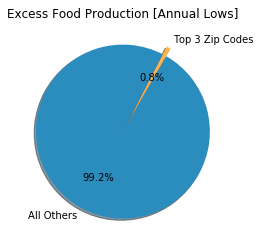

In [30]:
# TOP 3 EXCESS COMBINED V ALL OTHER ZIPS

low1 = low_excessfood_by_zipcode.iat[0,0]
low2 = low_excessfood_by_zipcode.iat[1,0]
low3 = low_excessfood_by_zipcode.iat[2,0]

fig1, ax1 = plt.subplots()
ax1.pie([(low1+low2+low3), ((final_output['EXCESSFOOD_TONYEAR_LOWEST'].sum())-low1-low2-low3)], 
        labels=['Top 3 Zip Codes', 'All Others'], 
        explode = [.1,0], 
        colors=['#feb24c','#2b8cbe'], 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=60)
ax1.set(aspect='equal', title='Excess Food Production [Annual Lows]')
plt.savefig('images/top3vALL.jpg')
plt.show()

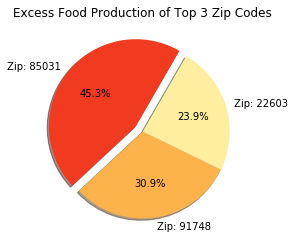

In [31]:
# TOP 3 EXCESS

fig2, ax2 = plt.subplots()
ax2.pie(low_excessfood_by_zipcode['EXCESSFOOD_TONYEAR_LOWEST'], 
        labels=['Zip: 85031', 'Zip: 91748', 'Zip: 22603'], 
        explode =[.1,0,0], 
        colors=['#f03b20', '#feb24c', '#ffeda0'], 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=60)
ax2.set(aspect='equal',title = 'Excess Food Production of Top 3 Zip Codes')
plt.savefig('images/top3breakdown.jpg')
plt.show()

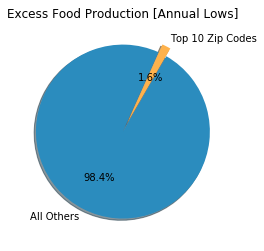

In [32]:
# TOP 10 EXCESS COMBINED V ALL OTHER ZIPS

top_10_low_zip = (final_output.groupby('ZIP_CODE')
                         ['EXCESSFOOD_TONYEAR_LOWEST', 'EXCESSFOOD_TONYEAR_HIGHEST']
                         .sum().sort_values('EXCESSFOOD_TONYEAR_LOWEST', ascending=False)
                         .nlargest(10, 'EXCESSFOOD_TONYEAR_LOWEST'))


test_list = []
for cell in top_10_low_zip['EXCESSFOOD_TONYEAR_LOWEST']: test_list.append(cell)
test_list.append((final_output['EXCESSFOOD_TONYEAR_LOWEST'].sum())-(top_10_low_zip['EXCESSFOOD_TONYEAR_LOWEST'].sum()))


fig3, ax3 = plt.subplots()
ax3.pie(([top_10_low_zip['EXCESSFOOD_TONYEAR_LOWEST'].sum(), 
        ((final_output['EXCESSFOOD_TONYEAR_LOWEST'].sum())
         -top_10_low_zip['EXCESSFOOD_TONYEAR_LOWEST'].sum())]), 
        labels=['Top 10 Zip Codes', 'All Others'], 
        explode = [.1,0], 
        colors=['#feb24c','#2b8cbe'], 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=60)
ax3.set(aspect='equal',title = 'Excess Food Production [Annual Lows]')
plt.savefig('images/top10vALL.jpg')
plt.show()

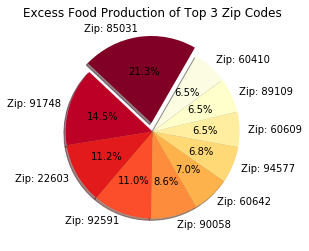

In [33]:
# TOP 10 EXCESS

labels_top10_low = (['Zip: 85031', 'Zip: 91748', 'Zip: 22603', 'Zip: 92591', 'Zip: 90058', 
                     'Zip: 60642', 'Zip: 94577', 'Zip: 60609', 'Zip: 89109', 'Zip: 60410'])
explode_top10_low = [.1,0,0,0,0,0,0,0,0,0]
colors_top10_low = ['#800026', '#bd0026', '#e31a1c', '#fc4e2a', '#fd8d3c', '#feb24c', '#fed976', '#ffeda0', '#ffffcc', '#fcfce3']

fig4, ax4 = plt.subplots()
ax4.pie(top_10_low_zip['EXCESSFOOD_TONYEAR_LOWEST'], 
        labels=labels_top10_low, 
        explode = explode_top10_low, 
        colors=colors_top10_low, 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=60)
ax4.set(aspect='equal',title = 'Excess Food Production of Top 3 Zip Codes')
plt.savefig('images/top10breakdown.jpg')
plt.show()